**注**：
- 由于数据量太大还没对模型进行太多调参
- 此代码在本人电脑上可以跑通，kaggle上也能跑通
- kaggle上拥有可分享版本（调参版本），目前还未施工完成，着急的话我把它分享出来
- 调参部分请直接在本文档搜索关键词：<span style="background-color:yellow">参数
- <span style="color:red">使用前请先在终端中输入：</span><span style="color:yellow">```pip install -r requirements.txt```</span><span style="color:red">以确保环境正确</span>
- <span style="background-color:yellow">存在梯度爆炸的情况出现，请在训练时谨慎修改学习率</span>

## 1. 库导入

In [1]:
# 库导入
import os
import math
import torch
import random
import warnings
import numpy as np 
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.multiprocessing as mp
from torch.autograd import Variable
from keras.preprocessing import sequence
from torch.utils.data import Dataset, DataLoader
from prefetch_generator import BackgroundGenerator
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.metrics import accuracy_score, f1_score,precision_score

## wifi信号（x）
## 前排提示 
## 因为这份代码里面被本人删了又改改了又删 可能部分地方有些逻辑重复 望轻喷
## 若无独显建议使用kaggle提供的资源进行运行

warnings.filterwarnings("ignore")
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False


## 2. 数据查看及整合后的数据处理函数

### 2.1 数据查看及图像绘制

In [2]:
# 文件读取
headers=["Tweet ID","entity","sentiment","Tweet content"]
train_data=pd.read_csv('./archive/twitter_training.csv',header=None,names=headers)
val_data=pd.read_csv('./archive/twitter_validation.csv',header=None,names=headers)

In [3]:
train_data.head(100)

,Tweet ID,entity,sentiment,Tweet content
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
...,...,...,...,...
95,2416,Borderlands,Neutral,I hate that this easy horrible modifier event ...
96,2417,Borderlands,Negative,Grounded almost looked pretty cool even despit...
97,2417,Borderlands,Negative,Grounded looked cool despite the borderline un...
98,2417,Borderlands,Negative,"Grosskreutz looked pretty cool, even despite t..."


In [4]:
val_data.head(100)

,Tweet ID,entity,sentiment,Tweet content
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...
...,...,...,...,...
95,9456,Overwatch,Negative,@BlizzardCS so when i try to buy overwatch wit...
96,11687,Verizon,Negative,@verizon Can you waive some data overage charg...
97,1589,Battlefield,Negative,No one buy battlefield 3 on steam! It doesn’t ...
98,3526,Facebook,Neutral,Our #HISAPerth #OBIawards ceremony is taking p...


In [5]:
## 查看标签数值化后的数据

# 提取出需要的部分
new_train_data = train_data.loc[:,['sentiment','Tweet content']].astype(str)
new_val_data = val_data.loc[:,['sentiment','Tweet content']].astype(str)

# 标签数值化
y_train,unique=pd.factorize(new_train_data['sentiment'])
new_train_data['sentiment']=y_train
y_val,unique=pd.factorize(new_val_data['sentiment'])
new_val_data['sentiment']=y_val

# 查看数据
new_train_data.head(100)

,sentiment,Tweet content
0,0,im getting on borderlands and i will murder yo...
1,0,I am coming to the borders and I will kill you...
2,0,im getting on borderlands and i will kill you ...
3,0,im coming on borderlands and i will murder you...
4,0,im getting on borderlands 2 and i will murder ...
...,...,...
95,1,I hate that this easy horrible modifier event ...
96,2,Grounded almost looked pretty cool even despit...
97,2,Grounded looked cool despite the borderline un...
98,2,"Grosskreutz looked pretty cool, even despite t..."


In [6]:
# 分词
tok=Tokenizer(num_words=100000)
tok.fit_on_texts(new_train_data['Tweet content'])
for i in range(10): print(f"{i+1}:{list(tok.word_index.keys())[i]}")

1:the
2:i
3:to
4:and
5:a
6:of
7:is
8:in
9:for
10:this


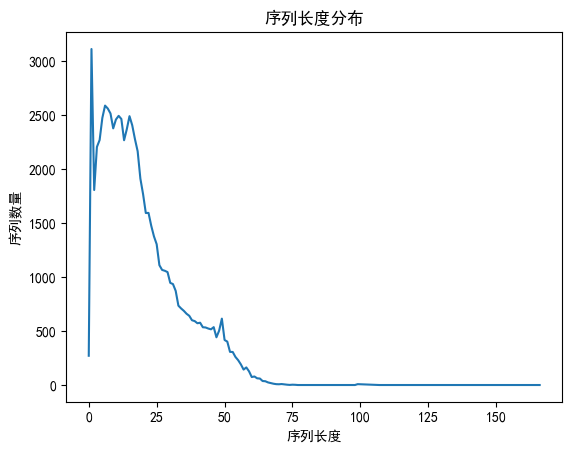

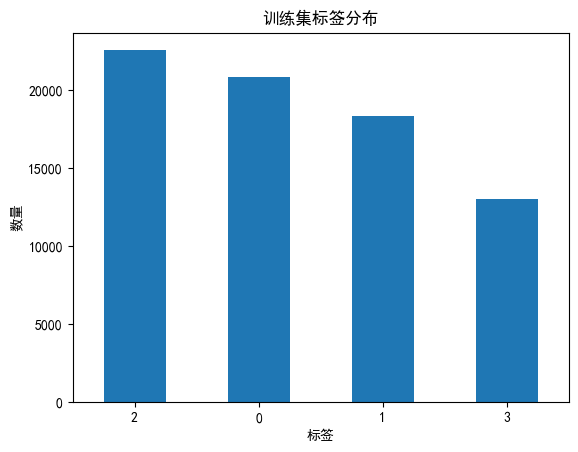

In [7]:
# 长度分布查看
x_train=tok.texts_to_sequences(new_train_data['Tweet content'].to_numpy())
len_ser=pd.Series([len(i) for i in x_train])
plt.plot(len_ser.value_counts().sort_index())
plt.xlabel('序列长度')
plt.ylabel('序列数量')
plt.title('序列长度分布')
plt.show()

# 查看情感类型分布
new_train_data['sentiment'].value_counts().plot(kind='bar')
plt.xticks(rotation=0)
plt.title('训练集标签分布')
plt.xlabel('标签')
plt.ylabel('数量')
plt.show()


### 2.2 整合后的数据导入及处理函数

In [8]:
def load_data(device='cpu',max_len=100):
    # 导入
    headers=["Tweet ID","entity","sentiment","Tweet content"]
    train_data=pd.read_csv('./archive/twitter_training.csv',header=None,names=headers)
    test_data=pd.read_csv('./archive/twitter_validation.csv',header=None,names=headers)

    # 取出有用部分
    new_train_data = train_data.loc[:,['sentiment','Tweet content']].astype(str)
    new_test_data = test_data.loc[:,['sentiment','Tweet content']].astype(str)

    # 标签数值化
    y_train,unique=pd.factorize(new_train_data['sentiment'])
    y_test,unique=pd.factorize(new_test_data['sentiment'])

    # 分词
    tok=Tokenizer(num_words=5000)
    tok.fit_on_texts(new_train_data['Tweet content'])

    x_train=tok.texts_to_sequences(new_train_data['Tweet content'].to_numpy())
    x_train = sequence.pad_sequences(x_train, maxlen=max_len)
    
    x_test=tok.texts_to_sequences(new_test_data['Tweet content'].to_numpy())
    x_test = sequence.pad_sequences(x_test, maxlen=max_len)

     # 转换为 tensor
    x_train = torch.tensor(x_train, dtype=torch.long, device=device)
    y_train = torch.tensor(y_train, dtype=torch.float32, device=device,requires_grad=True).view(-1,1)
    x_test = torch.tensor(x_test, dtype=torch.long, device=device)
    y_test = torch.tensor(y_test, dtype=torch.float32, device=device,requires_grad=True).view(-1,1)
    
    # 查看数据集大小
    print(f'训练集大小: {len(train_data)}')
    print(f'测试集大小: {len(test_data)}')
    
    return x_train,y_train,x_test,y_test,tok

# 数据集
class TwitterDataset(Dataset):
    def __init__(self,data,labels):
        self.data = data
        self.labels=labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self,idx):
        return self.data[idx], self.labels[idx]

class TwitterDataLoader(DataLoader):
    def __iter__(self):
        return BackgroundGenerator(super().__iter__(), max_prefetch=32)

## 3.Transformer的encoder模型

In [9]:
##### 模型部分
# Embedding部分
class InputEmbeddings(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(InputEmbeddings, self).__init__()
        self.embedding_dim = embedding_dim
        self.embed = nn.Embedding(vocab_size, embedding_dim)
        
    def forward(self, x):
        return self.embed(x) * math.sqrt(self.embedding_dim)
    
# 位置编码
class PositionalEncoding(nn.Module):
    def __init__(self, embedding_dim, max_len=100,dropout=1e-5):
        super(PositionalEncoding, self).__init__()
        self.encoding=torch.zeros(max_len,embedding_dim)
        
        #三角位置编码
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embedding_dim, 2) * -(math.log(10000.0) / embedding_dim))
        
        self.encoding[:, 0::2] = torch.sin(position * div_term)
        self.encoding[:, 1::2] = torch.cos(position * div_term)
        self.encoding = self.encoding.unsqueeze(0)        # 增加一个维度以对齐

        
    def forward(self, x):
        x = x + self.encoding[:, :x.size(1)].to(x.device)
        return x

# 多头注意力机制
## 注意力机制
def attention(q,k,v,mask=None,dropout=1e-5):
    d_k = q.size(-1)
    scores = torch.matmul(q,k.transpose(-2,-1)) / math.sqrt(d_k)
    
    if mask is not None:
        scores = scores.masked_fill(mask==0,-1e9)
    patten=nn.functional.softmax(scores,dim=-1)
    if dropout is not None:
        patten=nn.functional.dropout(patten,dropout)
    return torch.matmul(patten,v),patten

## 多头注意力机制
class MultiHeadAttention(nn.Module):
    def __init__(self,h,d_model,dropout=1e-5,linear_layers=3):
        super(MultiHeadAttention,self).__init__()
        assert d_model % h == 0
        self.d_k = d_model // h
        self.h = h
        self.linear_layers = nn.ModuleList([nn.Linear(d_model,d_model) for _ in range(linear_layers)])
        self.output_linear = nn.Linear(d_model,d_model)
        self.attention = attention
        self.dropout = nn.Dropout(dropout)
    
    def fordward(self,q,k,v,mask=None):
        if mask is not None:
            mask=mask.unsqueeze(1)
        batch_size = q.size(0)
        
        # 加入线性变换以适配多头的维度
        q,k,v = [l(x).view(batch_size,-1,self.h,self.d_k).transpose(1,2) for l,x in zip(self.linear_layers,(q,k,v))]
        
        x,_ = self.attention(q,k,v,mask=mask,dropout=self.dropout)
        
        x = x.transpose(1,2).contiguous().view(batch_size,-1,self.h*self.d_k)
        
        return self.output_linear(x)
    
# 自定义LeakyReLU激活函数类
class LeakyReLU(nn.Module):
    def __init__(self, negative_slope=0.1):
        super(LeakyReLU, self).__init__()
        self.negative_slope = negative_slope

    def forward(self, x):
        return F.leaky_relu(x, negative_slope=self.negative_slope)

# Transformer
class TransformerModel(nn.Module):
    def __init__(self,vocab_size,embed_size,n_heads,num_encoder_layers,hidden_dim,max_len=100,output_dim=4,dropout=0.01,self_made=False):
        super(TransformerModel,self).__init__()

        # 嵌入层
        self.embedding = nn.Embedding(vocab_size,embed_size)
        
        # 位置信息嵌入
        if dropout !=None: self.positional_encoding = PositionalEncoding(embed_size,max_len,dropout) 
        else: self.positional_encoding = PositionalEncoding(embed_size,max_len) 

        # 编码器
        if dropout !=None:encoder_layer = nn.TransformerEncoderLayer(d_model=embed_size,dim_feedforward=hidden_dim,nhead=n_heads,dropout=dropout,activation=LeakyReLU())
        else: encoder_layer = nn.TransformerEncoderLayer(d_model=embed_size,dim_feedforward=hidden_dim,nhead=n_heads,activation=LeakyReLU())
        self.transformer=nn.TransformerEncoder(encoder_layer,num_encoder_layers)
        
        # 前馈神经网络
        self.fc = nn.Linear(embed_size,output_dim)
        self.dropout = nn.Dropout(dropout)

    # def init_weights(self):

    #     for _, param in self.named_parameters():
    #         if param.dim() > 1: 
    #             nn.init.xavier_uniform_(param)  
    #         else:  
    #             nn.init.zeros_(param)
        
    #     # 对嵌入层单独初始化
    #     if isinstance(self.embedding, nn.Embedding):
    #         nn.init.uniform_(self.embedding.weight, -1, 1)
        
    #     # 对输出的全连接层进行初始化
    #     nn.init.xavier_uniform_(self.fc.weight)
    #     nn.init.zeros_(self.fc.bias)

    # def forward(self,src,src_mask=None):
    #     embedded = self.embedding(src)
    #     encoded = self.positional_encoding(embedded)
    #     # 调试
    #     # print(f"Input:{src.size()} Embeded:{embedded.size()} Encoded:{encoded.size()}") # 调试
    #     # if src_mask != None:
    #     #     mask= src_mask.unsqueeze(2)

    #     # if self.self_made:
    #     #     src_atten = self.att(encoded,encoded,encoded,mask)
    #     #     encoded = self.norm(encoded+src_atten)
    #     #     if mask!=None: encoded = encoded*mask
    #     #     b = encoded.sum(1) / (mask.sum(1) + 1e-5)
    #     #     return self.fc(b).squeeze(1)
        
    #     output = self.transformer(encoded)
    #     output = output.mean(dim=1)
    #     output = self.fc(self.dropout(output))
    #     output = nn.functional.softmax(output,dim=1)
    #     # output=torch.argmax(output,dim=1).float()
    #     # output=output.requires_grad_(requires_grad=True)
    #     return output
    
    def forward(self, src):
        embedded = self.embedding(src)
        encoded = self.positional_encoding(embedded)
        
        output = self.transformer(encoded)
        output = output.mean(dim=1)
        output = self.fc(self.dropout(output))
        return output

# 为实现loss下降加入warmup
class WarmupScheduler(torch.optim.lr_scheduler._LRScheduler):
    def __init__(self, optimizer, warmup_steps, d_model, last_epoch=-1):
        self.warmup_steps = warmup_steps
        self.d_model = d_model
        super(WarmupScheduler, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        # 当前优化器步数
        step = max(1, self.last_epoch + 1)
        # 基于公式计算学习率
        scale = self.d_model ** -0.5
        lr = scale * min(step ** -0.5, step * self.warmup_steps ** -1.5)
        return [lr for base_lr in self.base_lrs]
    

In [10]:
# 训练函数
def train_model(model,x,y,optimizer,criterion,schedule,batch_size=64,epoches=200,clip_value=None,norm=2,each_out=False):

    scheduler = schedule
    model.train()
    loss_list=[]
    acc_list=[]

    dataset=TwitterDataset(x,y)
    train_loader=TwitterDataLoader(dataset,batch_size=batch_size,shuffle=True)
    
    for epoch in range(epoches):
        loss_epoch=0
        for data,label in train_loader: 
            
            # 梯度计算 清零及更新
            optimizer.zero_grad()
            output = model(data)

            label=label.squeeze(1).long()
            loss = criterion(output,label)

            loss.backward()
            # 梯度调试
            # for name, parms in model.named_parameters(): print('-->name:', name, '-->grad_requirs:',parms.requires_grad,' -->grad_value:',parms.grad)
            # 梯度调试 (＃°Д°)
            
            optimizer.step()

            # 梯度裁剪
            if clip_value!=None: torch.nn.utils.clip_grad_norm_(model.parameters(),clip_value,norm)

            # 准确率和损失计算
            output=torch.argmax(output,dim=1).float()
            loss_epoch+=loss.item()
            acc_epoch = accuracy_score(label.detach().cpu().numpy(), output.detach().cpu().numpy())

        # 学习率更新
        scheduler.step()
        
        # 进度显示
        loss_list.append(loss_epoch/len(train_loader))
        acc_list.append(acc_epoch)
        if each_out: print(f"Epoch {epoch+1}/{epoches} Loss: {loss_epoch/len(train_loader)} Accuracy: {acc_epoch}")
        if (epoch%10==0)and epoch!=0: print(f'Epoch {epoch+1}/{epoches} Mean Loss: {np.mean(loss_list[epoch-10:epoch])} Mean Acurracy: {np.mean(acc_list[epoch-10:epoch])}')

    return loss_list,acc_list

# 评估函数
def eval_model(model,x,y,batch_size=64,criterion=nn.CrossEntropyLoss()):
    model.eval()

    dataset=TwitterDataset(x,y)
    train_loader=TwitterDataLoader(dataset,batch_size=batch_size,shuffle=True)

    # 验证
    with torch.no_grad():
        for data,label in train_loader:
            output = model(data)
            label=label.squeeze(1).long()
            loss = criterion(output,label)
            output=torch.argmax(output,dim=1).float()
            acc_epoch = accuracy_score(label.detach().cpu().numpy(), output.detach().cpu().numpy())
            print(f"Loss: {loss.item()} Accuracy: {acc_epoch}")
        output = model(x)
        output=torch.argmax(output,dim=1).float()
        label=y.squeeze(1).detach().cpu().numpy()

    # 评价指标计算
    acc=accuracy_score(label,output.detach().cpu().numpy())
    pre=precision_score(label,output.detach().cpu().numpy(),average='weighted')
    f1=f1_score(label,output.detach().cpu().numpy(),average='weighted')

    print(f"Test Dataset Performance:\nAccuracy : {acc:.4f}\nPrecision : {pre:.4f}\nF1 Score : {f1:.4f}")
    return acc,pre,f1

**可调参数如下:** </br>
|参数|说明|
|----|----|
|seed|随机种子|
|batch_size|batch大小|
|n_heads|多头注意力机制的头数|
|embedding_dim|词嵌入维度|
|learning_rate|学习率|
|hidden_dim|全连接层的隐藏层维度|
|num_layers|encoder的层数|
|dropout|dropout概率|
|epoches|训练轮数|

建议调整:
- batch_size 
- n_heads
- embedding_dim
- learning_rate <span style="background-color:yellow">学习率超过1e-3就会梯度消失🥲🥲 所以补药超过1e-3啊(っ °Д °;)っ </span>
- hidden_dim
- learning_rate
- num_layers

In [11]:
## 参数及相关设置
seed=2025
batch_size=64
n_head=2
embedding_dim=16 # 注意: embedding_dim % n_head ==0
learning_rate=5e-8# 学习率超过1e-3就会出现梯度消失的情况，补药超过1e-3啊
hidden_dim=16
epoches=50
drop_out=0.0001
num_encoders=1
mp.set_start_method('spawn', force=True)  # 设置启动方法为 spawn
# clip=1500
norm_type=2
max_len=200
warm_up_steps=200

In [12]:
## 设置随机种子
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

## 数据读入
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
x_train,y_train,x_test,y_test,tok = load_data(device=device,max_len=max_len)

vocab_size=len(tok.word_index)+1
## 模型定义
model=TransformerModel(hidden_dim=hidden_dim,vocab_size=vocab_size,embed_size=embedding_dim,n_heads=n_head,num_encoder_layers=num_encoders,max_len=max_len)
# model.init_weights()
if torch.cuda.device_count() > 1:
    print(f"正在使用 {torch.cuda.device_count()} GPU进行运算")
    model = nn.DataParallel(model)
elif torch.cuda.device_count() == 1:
    print(f"正在使用 {torch.cuda.device_count()} GPU进行运算")
else: print("正在使用 CPU 进行运算")

model.to(device)

训练集大小: 74682
测试集大小: 1000
正在使用 CPU 进行运算


TransformerModel(
  (embedding): Embedding(33785, 16)
  (positional_encoding): PositionalEncoding()
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
        )
        (linear1): Linear(in_features=16, out_features=16, bias=True)
        (dropout): Dropout(p=0.01, inplace=False)
        (linear2): Linear(in_features=16, out_features=16, bias=True)
        (norm1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.01, inplace=False)
        (dropout2): Dropout(p=0.01, inplace=False)
        (activation): LeakyReLU()
      )
    )
  )
  (fc): Linear(in_features=16, out_features=4, bias=True)
  (dropout): Dropout(p=0.01, inplace=False)
)

In [13]:
# 模型训练
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)
criterion=nn.CrossEntropyLoss()
scheduler = WarmupScheduler(optimizer, warmup_steps=warm_up_steps, d_model=embedding_dim)
loss_list, acc_list=train_model(model,x_train,y_train,optimizer,criterion,batch_size=batch_size,epoches=epoches,norm=norm_type,schedule=scheduler,each_out=True)


Epoch 1/50 Loss: 1.4252386777546024 Accuracy: 0.3793103448275862
Epoch 2/50 Loss: 1.366748009569745 Accuracy: 0.3103448275862069
Epoch 3/50 Loss: 1.3645432216036288 Accuracy: 0.3620689655172414
Epoch 4/50 Loss: 1.360870409645172 Accuracy: 0.3275862068965517
Epoch 5/50 Loss: 1.3500004174265987 Accuracy: 0.3793103448275862
Epoch 6/50 Loss: 1.3049192087407182 Accuracy: 0.43103448275862066
Epoch 7/50 Loss: 1.247891728348883 Accuracy: 0.46551724137931033
Epoch 8/50 Loss: 1.19875760484988 Accuracy: 0.39655172413793105
Epoch 9/50 Loss: 1.144845351819412 Accuracy: 0.4482758620689655
Epoch 10/50 Loss: 1.100821206175372 Accuracy: 0.5517241379310345
Epoch 11/50 Loss: 1.0637908513564378 Accuracy: 0.6206896551724138
Epoch 11/50 Mean Loss: 1.2864635835934013 Mean Acurracy: 0.4051724137931035
Epoch 12/50 Loss: 1.0283461648782504 Accuracy: 0.6206896551724138
Epoch 13/50 Loss: 0.986796982439543 Accuracy: 0.6896551724137931
Epoch 14/50 Loss: 0.9505430290917607 Accuracy: 0.603448275862069
Epoch 15/50 Los

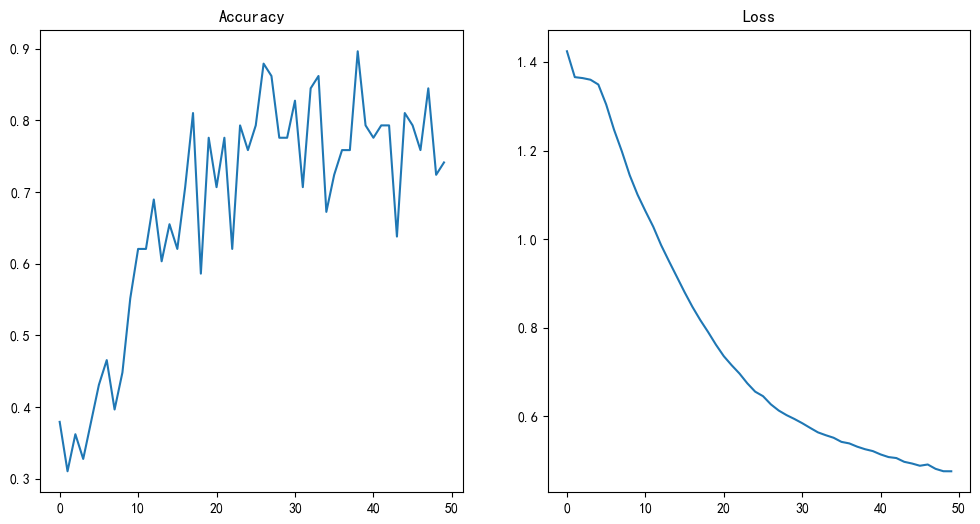

In [18]:
# 训练结果可视化
plt.subplots(1,2,figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(acc_list)
plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(loss_list)
plt.title("Loss")
plt.show()

In [19]:
# 评估模型
eval_model(model,x_test,y_test)

Loss: 3.2105519771575928 Accuracy: 0.46875
Loss: 4.072857856750488 Accuracy: 0.4375
Loss: 3.200695753097534 Accuracy: 0.53125
Loss: 3.422130584716797 Accuracy: 0.546875
Loss: 3.2280778884887695 Accuracy: 0.578125
Loss: 2.9520719051361084 Accuracy: 0.546875
Loss: 3.3740456104278564 Accuracy: 0.5
Loss: 2.657958507537842 Accuracy: 0.59375
Loss: 3.339754104614258 Accuracy: 0.59375
Loss: 3.368163824081421 Accuracy: 0.5625
Loss: 3.086914539337158 Accuracy: 0.515625
Loss: 2.0060040950775146 Accuracy: 0.59375
Loss: 2.2748377323150635 Accuracy: 0.5625
Loss: 2.9222822189331055 Accuracy: 0.453125
Loss: 3.2645342350006104 Accuracy: 0.5
Loss: 2.7310774326324463 Accuracy: 0.55
Test Dataset Performance:
Accuracy : 0.5300
Precision : 0.5208
F1 Score : 0.5237


(0.53, 0.5207549536869734, 0.5236809713704729)

In [20]:
# 模型及结果保存
preds = torch.round(torch.sigmoid(model(x_test)))
preds = preds.cpu().detach().numpy()
preds = np.squeeze(preds)

os.makedirs('./model',exist_ok=True)
os.makedirs('./predoictions',exist_ok=True)
np.save('./predoictions/Transformer_Predictions.npy',preds)
torch.save(model.state_dict(),'./model/Transformer_Model.pth')